In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib


In [1]:
import tensorflow as tf  #building and training
import os   #interact with the file system, create directories, list files in a directory
import cv2  #RT computer vision, image processing
import imghdr   #determines the type of image contained in a file
from PIL import Image  #Python Imaging Library for opening, manipulating, and saving many different image file formats


C:\Users\User\AppData\Local\Temp\ipykernel_18216\996540622.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr   #determines the type of image contained in a file


In [2]:
import numpy as np
import tensorflow as tf
import random
import os

#seed_value = 40 88, 83, 83
seed_value = 40
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Loadinf dataset

In [3]:
import numpy as np  #numerical computing
from matplotlib import pyplot as plt  #plotting


In [4]:
data = tf.keras.utils.image_dataset_from_directory('data') #loading data using Keras from tensorflow, taking alook at it
#keras helper, builds an image dataset itself, no need labelling 


Found 2457 files belonging to 3 classes.


In [7]:
tf.keras.utils.image_dataset_from_directory??
#batches image, resize img in 256x256, shuffles..


In [5]:
data_iterator = data.as_numpy_iterator() 
#data is not loaded entirely into memory, but rather it's loaded in batches as required.,it is just a generator
#to access each img like data[0] we need the iterator, allows to loop through data

batch = data_iterator.next() #grabs a batch of data from iterator, shape-2: image(loaded as numpyarray), labels


In [7]:
batch[0].shape #images represented as numpy arrays
#32 images of shape 256x256x3 (RGB channel) in this one random batch


(32, 256, 256, 3)

In [8]:
batch[1] #labels 0:adv, 1: early, 2:healthy (we dont know for sure which label is for which class)


array([0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0,
       1, 2, 2, 1, 2, 1, 2, 1, 1, 1])

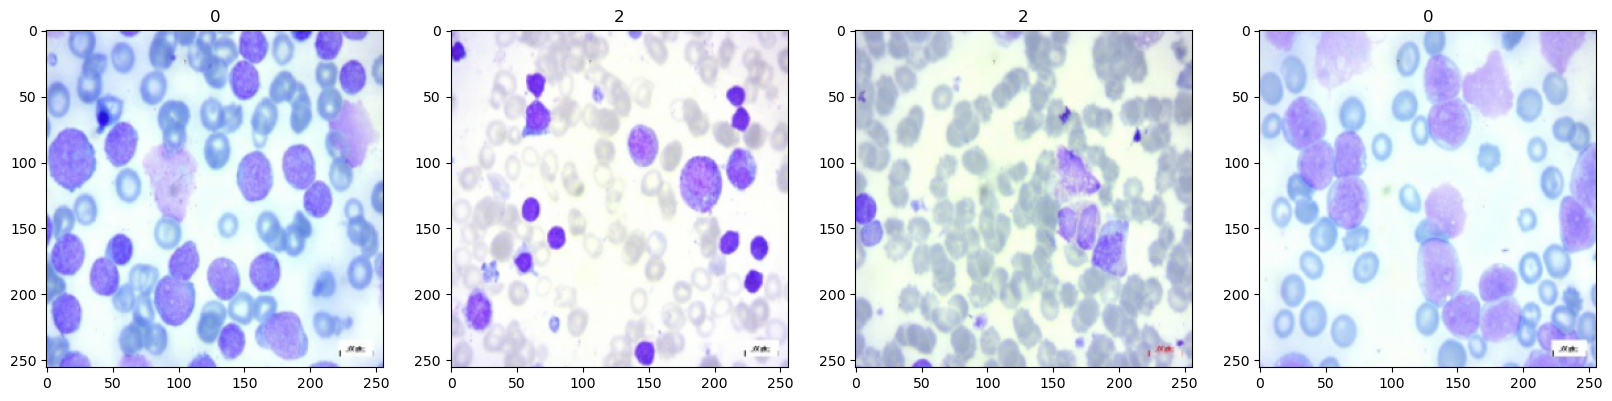

In [9]:
#figures whihc labels is for whihc class
#0: advanced, 1: early, 2: healthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #matplotlib's subplot function to plot 4 img at a time
for idx, img in enumerate(batch[0][:4]): #iterate over first 4 img in the batch
    ax[idx].imshow(img.astype(int)) #display current img
    ax[idx].title.set_text(batch[1][idx])  #display corresponding labe
    

Preprocess data (Scale image values between 0-1)

In [6]:
data = data.map(lambda x,y: (x/255, y))
#map: allows us to apply tranformations on the images as they are loaded
#lambda: takes input images(x) and labels(y)
#x/255:returns scaled images so it between 0-1 for faster optimization

'''
zip is also a function of tensorflow api, combines a set of features and labels
skip:
'''


'\nzip is also a function of tensorflow api, combines a set of features and labels\nskip:\n'

In [7]:
scaled_iterator = data.as_numpy_iterator()
#gconverts scaled dataset to numpy ietrator, allows access to the data in batches
batch = scaled_iterator.next() #.next()grabs the next batch


In [12]:
batch[0].max() #checking if it is scaled


1.0

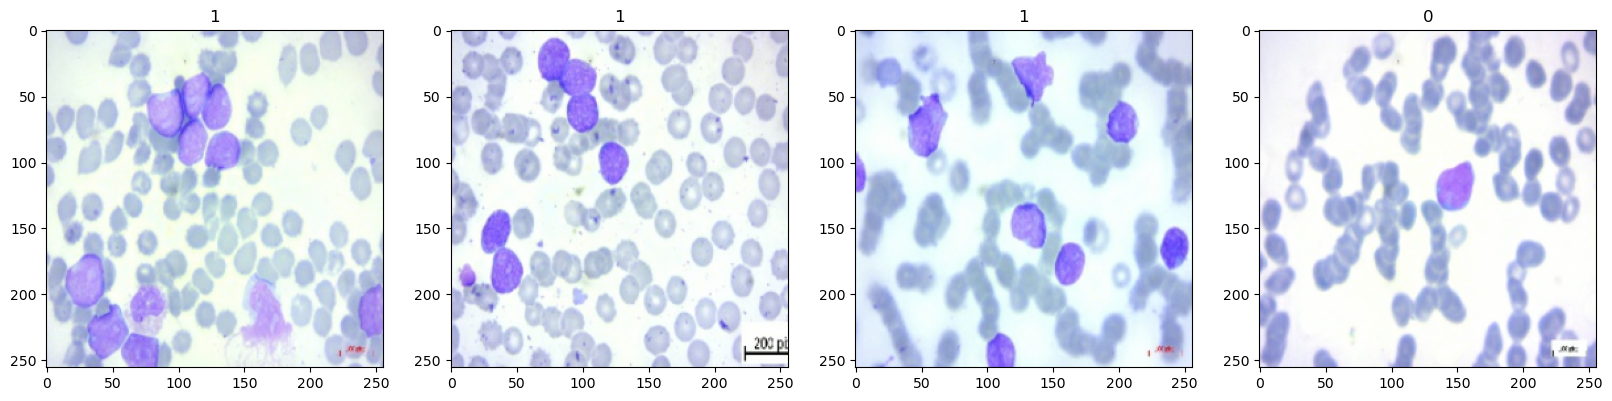

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #this line is changed so it doesnt take integers, or they'll all be white/black, allow floats
    ax[idx].title.set_text(batch[1][idx])
    

Split the data into test and trainin sets

In [14]:
len(data) #we have 77 batches, each having 32 images


77

In [8]:
train_size = int(len(data)*0.7) #training set is 70% of the image dataset, 53 batches
val_size = int(len(data)*0.2) #20% for validtion set, 15: evaluates model while we are training can be used to fine tune the model
test_size = int(len(data)*0.1) #10% tetsing, 7, do evaluation on the accuracy

train = data.take(train_size)
val = data.skip(train_size).take(val_size) #skip first 53, take next 15
test = data.skip(train_size+val_size).take(test_size) #skip first 53 and 15, take rest 7

#take(): defines how much data we are going to take in that particular partition (train/tes/val)
#skip(): skip batches that we alreay took for train size/val size and allocate the remaining to that partition

In [16]:
len(train) #taking 53 batches to allocate to our training data


53

Model

In [9]:
train


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
from tensorflow.keras.models import Sequential
#sequential: one inpute one output, functional: multiple input multiple output
#build a neural network layer-by-layer in a linear stack.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
#conv2d: CNN layer, maxpool2d: condenses images, dense: FC layer, flatten: changes to a format that
#the FC layer can process, get one output at the end, Input: specify input shape in1st layer

from tensorflow.keras.regularizers import l2
#adds a penalty proportional to the square of the value of the weights.

In [11]:
model = Sequential() #create a model, add the layers squentially, with regularization adn droput to prevent overftting

# Define the input shape using the Input layer
model.add(Input(shape=(256, 256, 3)))

#adding a conv layer and a max pooling with model.add()
#conv: 16 filters of 3x3, stride: 1, activation func: ReLU (converts negative to 0, positives remain, take non-linear patterns
model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D()) #take max value in 2x2 window after the relu act. and return back the value
model.add(Dropout(0.25))  #Randomly sets 25% of the input units to 0 during each training step.

model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25)) 

model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25)) 
model.add(Flatten()) #Converts the 3D output of the last convolutional layer to a 1D vecto

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01))) #256 neurons
model.add(Dropout(0.5))  # 50% of input units to 0
model.add(Dense(3, activation='softmax')) #one output 0/1/2 (softmax activation)

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Print the model summary
model.summary()

#flatten: 14400 = 30x30x16 (condensed to 1 dimesion)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Data scalingand training

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #preprocess the image data by scaling pixel values.

# Paths to your training and validation directories
train_dir = 'train3'
val_dir = 'val3'

# Create ImageDataGenerator instances for rescaled training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 img using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    classes=['class 0', 'class 1', 'class 2']  # Specify your classes here
)

# Flow validation images in batches of 32 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    classes=['class 0', 'class 1', 'class 2']  # Specify your classes here
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs") #log out model taining as it trains, so we can see how the model performed at a time
#model.fit is the training component
#takes in arg training data, running the calidation data as well to see how well the model perfomred by plotting it
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[tensorboard_callback])


Found 1715 images belonging to 3 classes.
Found 488 images belonging to 3 classes.
Epoch 1/20


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 641ms/step - accuracy: 0.3806 - loss: 5.7712 - val_accuracy: 0.3975 - val_loss: 2.3745
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 647ms/step - accuracy: 0.5535 - loss: 2.0068 - val_accuracy: 0.6742 - val_loss: 1.4340
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 568ms/step - accuracy: 0.6978 - loss: 1.3155 - val_accuracy: 0.6803 - val_loss: 1.2300
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 635ms/step - accuracy: 0.7458 - loss: 1.0362 - val_accuracy: 0.6762 - val_loss: 1.1457
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.7847 - loss: 0.8985 - val_accuracy: 0.7541 - val_loss: 0.9041
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 646ms/step - accuracy: 0.7698 - loss: 0.8959 - val_accuracy: 0.7295 - val_loss: 0.9150
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 647ms/step - accuracy: 0.8233 - loss: 0.7952 - val_accuracy: 0.7623 - val_loss: 0.8656
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 626ms/step - accuracy: 0.8017 - loss: 0.8035 - val_accuracy: 0.807

#### Model was overfitting, as loss was going down but validation loss was rising. Vlidation accuracy was also decreasing when it was supposed to increase.

####fixed overfitting to a significant degree,training accuracy (88%) is high, indicating that model has learned well from the training data.
validation accuracy (82.99%) being closely aligned to accuracy suggests overfitting problem being solves
The testing accuracy (82.77%) being close to the validation accuracy, suggesting that model generalizes reasonably well to unseen data.

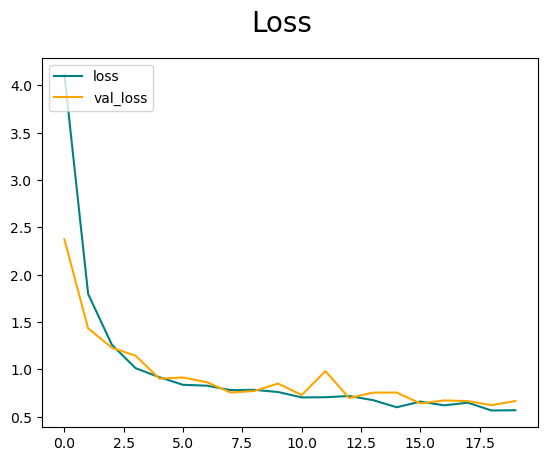

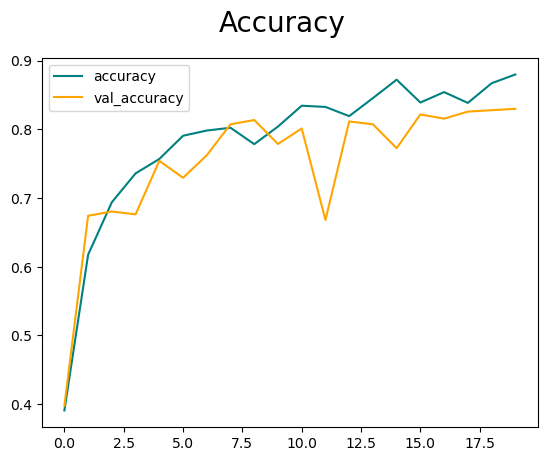

In [13]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [14]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
import numpy as np
#test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'test3',  
    target_size=(256, 256), 
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=['class 0', 'class 1', 'class 2'] 
)

#Initialize metrics
cat_acc = CategoricalAccuracy()
precision = Precision()
recall = Recall()


all_y_true = [] #list to store ground truth labels
all_y_pred = [] #precidted labels

num_batches = len(test_generator)
for i, batch in enumerate(test_generator):  #loop through test datat batches
    if i >= num_batches:  
        break #Stop the loop after processing all batches
    
    X, y = batch #x: batch of img, y: ground truth, yhat predictions by model
    yhat = model.predict(X, verbose=0)
    
    # Append ground truth and predictions
    all_y_true.append(y)
    all_y_pred.append(yhat)


all_y_true = np.concatenate(all_y_true)  #Converts lists of arrays into single arrays.
all_y_pred = np.concatenate(all_y_pred)

#np.argmax: converts one-hot encoded labels to class indices.
#to categorical: converts class indices back to one-hot encoded vectors for compatibility with metrics.
# Convert y and yhat to categorical if they are not already
y_true_cat = tf.keras.utils.to_categorical(np.argmax(all_y_true, axis=1), num_classes=3)
y_pred_cat = tf.keras.utils.to_categorical(np.argmax(all_y_pred, axis=1), num_classes=3)

# Update state for metrics with labels and predictions
cat_acc.update_state(y_true_cat, y_pred_cat)
precision.update_state(y_true_cat, y_pred_cat)
recall.update_state(y_true_cat, y_pred_cat)

#compute results and print
print(f'Categorical Accuracy: {cat_acc.result().numpy()}')
print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')


Found 249 images belonging to 3 classes.
Categorical Accuracy: 0.827309250831604
Precision: 0.827309250831604
Recall: 0.827309250831604


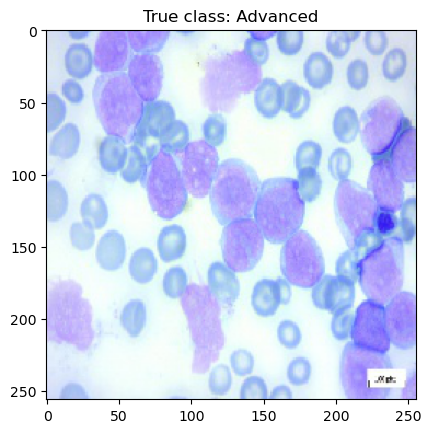

Predicted class is Advanced
Prediction probabilities: [[0.44027454 0.40710777 0.15261763]]


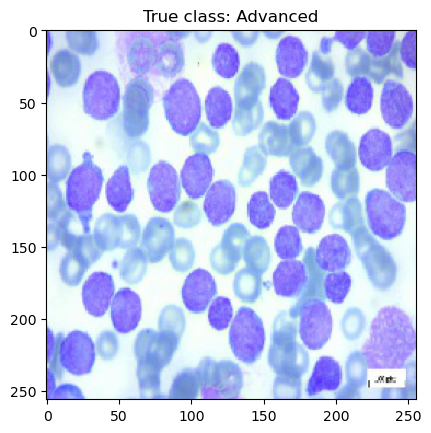

Predicted class is Advanced
Prediction probabilities: [[0.973089   0.00658285 0.0203282 ]]


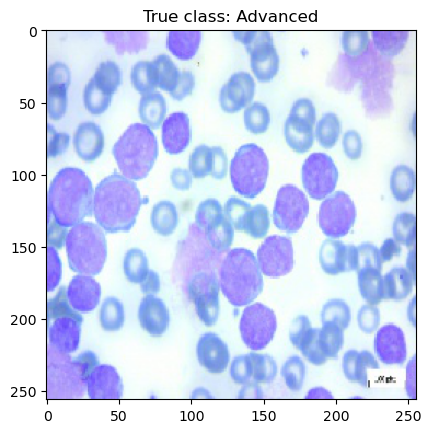

Predicted class is Advanced
Prediction probabilities: [[0.830531   0.06427992 0.10518914]]


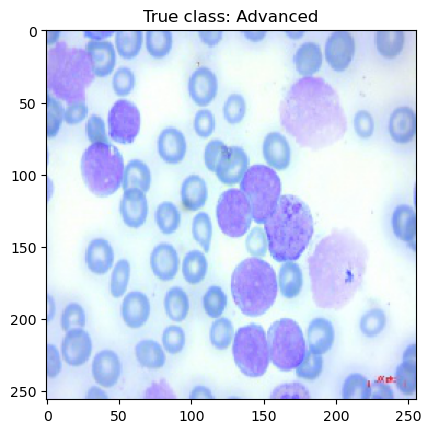

Predicted class is Early
Prediction probabilities: [[0.37066054 0.4036289  0.22571054]]


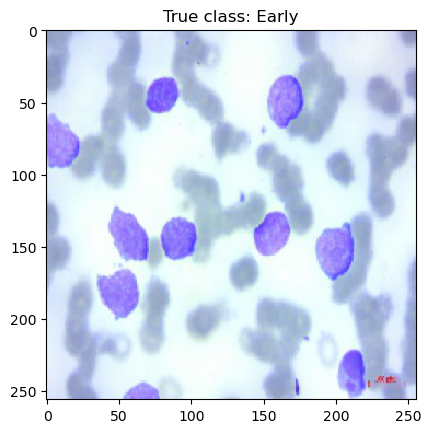

Predicted class is Early
Prediction probabilities: [[2.2753750e-04 9.5678318e-01 4.2989247e-02]]


In [15]:
class_labels = {0: 'Advanced', 1: 'Early', 2: 'Healthy'}
# Check individual predictions for images in the test set
for i in range(5):  # Display 5 test images and their predictions
    img = test_generator[i][0][0]  # Get the first image of the i-th batch
    y_true = np.argmax(test_generator[i][1][0])  # Get the true label of the first image

    plt.imshow(img)
    plt.title(f'True class: {class_labels[y_true]}') #title: clas label
    plt.show()
    
    img = np.expand_dims(img, 0)  #changing its shape from (256, 256, 3) to (1, 256, 256, 3) to match the model's expected input shape.

    yhat = model.predict(img, verbose=0) #predict input
    predicted_class = np.argmax(yhat, axis=1)[0] #retrieves the predicted class index from the prediction probabilities.
    
    print(f'Predicted class is {class_labels[predicted_class]}')
    print(f'Prediction probabilities: {yhat}')
    

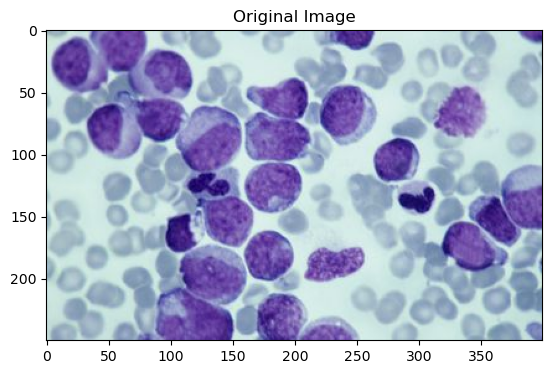

In [16]:
img_path = 'earlytest5.jpg'
img = cv2.imread(img_path) #cv2 for img processing, read img in BGR
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Convert to RGB, training used RGB
plt.imshow(img_rgb)
plt.title('Original Image')
plt.show()


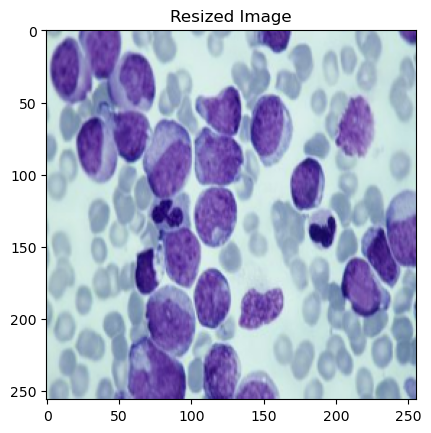

In [17]:
resize = tf.image.resize(img_rgb, (256, 256)) #resize and inpput img in RGB
plt.imshow(resize.numpy().astype(int)) #convert any datat type to int
plt.title('Resized Image')
plt.show()


In [18]:
resize = np.expand_dims(resize, 0)  # Expand dimensions to match model input shape
resize = resize / 255.0  # Normalize the image

# Make a prediction
yhat = model.predict(resize, verbose=0) #use trained model to predict
predicted_class = np.argmax(yhat, axis=1)[0] #Finds the index of the class with the highest predicted probability.

# Interpret the prediction
print(f'Predicted class is {class_labels[predicted_class]}')
print(f'Prediction probabilities: {yhat}')


Predicted class is Early
Prediction probabilities: [[2.293031e-04 9.533222e-01 4.644845e-02]]
